# Load libraries needed

In [317]:
#Pandas, yay
import pandas as pd
from pandas import ExcelWriter, ExcelFile

#Numpy
import numpy as np

#NLTK
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop = stopwords.words('english')
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

#SkLearn
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from xgboost import plot_importance

#Other
import string
import warnings
#These pink warnigns that say stuff about versions annoy me
warnings.filterwarnings("ignore")
import seaborn as sns

#Word Cloud Libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

#Read in the data
df_txpl = pd.read_excel('txpl_project_updated.xlsx')

#Shape of the data
df_txpl.shape

(6871, 197)

# Cute Word Cloud

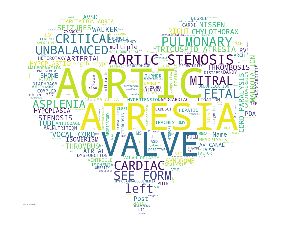

In [319]:
#We don't want NA in our cute word cloud...it will make it ugly
data = df_txpl.dropna(subset=['CHD_OTHSP','SPECOTH','SURGERY_HISTORY'])

#Conat all the strings we want
text = str(data.CHD_OTHSP) + str(data.SPECOTH) + str(data.SPECOTH)

#Make it a heart shape because PHTS
heart_mask = np.array(Image.open("heart2.jpg"))
                    
wordcloud = WordCloud(mask=heart_mask,background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear",)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [320]:
#Check to make sure we have the columns and it imported 
print(df_txpl.columns)

#The categorical variables needed to one hot encode
cat_var = [key for key in dict(df_txpl.dtypes) if dict(df_txpl.dtypes)[key] in ['object']] 

#Do not want to hot encode these they are our text fields of interest.  
cat_var.remove('CHD_OTHSP')
cat_var.remove('SPECOTH')
cat_var.remove('SURGERY_HISTORY')

#show the categorical
print(cat_var)

Index(['AGE_LISTING', 'AGE_TXPL', 'STATLIST', 'SLVAD', 'SLECMO', 'SLVENT',
       'HXARRYTH', 'HXCPR', 'HXDIAB', 'HXGI',
       ...
       'TXHDL_R', 'TXVLDL_R', 'eGFR_TXPL', 'GRAFT_LOSS', 'INT_GRAFT_LOSS',
       'SURGERY_HISTORY', 'SV_GROUP', 'LSNYHA_T', 'LSRHFCL_T', 'PATIENT_ID'],
      dtype='object', length=197)
['STATLIST', 'SLINODS', 'SEX', 'TXSTAT', 'DONORSEX', 'STATUS_LISTING', 'STATUS_TXPL', 'LSNYHA_T', 'LSRHFCL_T']


# Prepare Data 

In [321]:
#This unnamed column gets added as an index from importing with pandas, not sure how to drop it in the 
#import so just dropping it here
df_txpl.drop(df_txpl.filter(regex="Unname"),axis=1, inplace=True)

#Looking at the data specs
print(df_txpl.shape)
print(df_txpl.head())
print(df_txpl.describe())

(6871, 197)
   AGE_LISTING  AGE_TXPL STATLIST  SLVAD  SLECMO  SLVENT  HXARRYTH  HXCPR  \
0       15.855    16.047        1  0.000   0.000   0.000     1.000    nan   
1        5.065     5.101        1  0.000   0.000   0.000     0.000    nan   
2        9.090     9.279        2  0.000   0.000   0.000     0.000    nan   
3        0.723     1.136        2  0.000   0.000   0.000     0.000    nan   
4        3.981     4.115        2  0.000   0.000   0.000     0.000    nan   

   HXDIAB  HXGI  ...  TXHDL_R  TXVLDL_R  eGFR_TXPL  GRAFT_LOSS  \
0   0.000 0.000  ...      nan       nan     81.050           1   
1   0.000 0.000  ...      nan       nan    123.889           0   
2   0.000 0.000  ...      nan       nan    135.245           1   
3   0.000 0.000  ...      nan       nan     71.255           1   
4   0.000 1.000  ...      nan       nan     61.263           1   

   INT_GRAFT_LOSS                        SURGERY_HISTORY  SV_GROUP  \
0           2.965  Physician Reported No Other Surgeries  

In [323]:
#One hot encode everything categorical
df_processed = pd.get_dummies(df_txpl, prefix_sep="_",columns=cat_var)

#Text variables to drop from the first model
text = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] in ['object']] 

#These are the text variables now because we transformed the others
print(text)

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
print(df_processed['SV_GROUP'].value_counts())

#Set to only SV just to ensure I am getting 1803
df_filtered_list = df_processed[df_processed['SV_GROUP'] == 1]

#I'm just filtering above to see different numbers for testing
print(df_processed.shape)
print(df_filtered_list.shape)

['SPECOTH', 'CHD_OTHSP', 'SURGERY_HISTORY']
0    5068
1    1803
Name: SV_GROUP, dtype: int64
(6871, 222)
(1803, 222)


In [324]:
#Model without text fields
df_model1 = df_processed.drop(text,axis=1)

In [325]:
df_model1

#Look at missing
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))

#Eliminate missing data that is more than 25%
filter_missing = df_model1[df_model1.columns[df_model1.isnull().mean() < 0.25]]

missing(filter_missing)

TXSA_R                                                                                                                                   22.350
HXMED                                                                                                                                    22.240
LCREAT_R                                                                                                                                 20.940
LSSAB_R                                                                                                                                  19.150
TXICU                                                                                                                                    17.420
TXVENT                                                                                                                                    7.920
HXCPR                                                                                                                                   

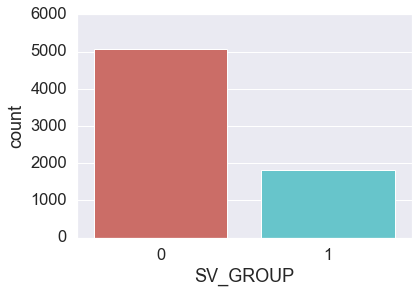

In [326]:
#Impute with the median
df_imp = filter_missing.fillna(filter_missing.median())

df_imp

#Look at our outcome ~1800 are single ventricle
sns.set(font_scale=1.5)
countplt=sns.countplot(x='SV_GROUP', data=df_imp, palette ='hls')
plt.show()

# Prepare Data with Test Train Split

In [327]:
#Every column except those that woudn't make sense
#Patient ID is the ID of the patient, the target variable and then the three surgeries that
#Define a patient having single ventricle
cols_all = [col for col in df_imp.columns if col not in ['PATIENT_ID','SV_GROUP','CHD_HLH','CHD_TRIAT','CHD_DILV','CHD_SV']]

#Using ALL features in PHTS
data_all = df_imp[cols_all]

#Only variables with less than 25% missing
print("Percent Missing for Features Included in Model")
print(missing(filter_missing[cols_all]))

#The predictor
target = df_imp['SV_GROUP']

#Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_all,target, test_size = 0.2)

#Print dimensions
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


Percent Missing for Features Included in Model
TXSA_R                                                                                                                                   22.350
HXMED                                                                                                                                    22.240
LCREAT_R                                                                                                                                 20.940
LSSAB_R                                                                                                                                  19.150
TXICU                                                                                                                                    17.420
TXVENT                                                                                                                                    7.920
HXSHOCK                                                                                  

## Looking at Features which Give the Most Information

In [328]:
#Altering this to display mutual information because there are negative values in age so chisq cannot be determined
#Because we have negative values in a variable (AGE) because babies can be put on the weight list before they are born
class SelectKBestCustom(SelectKBest):

    # Changed here
    def fit(self, X, y, discrete_features='auto'):
        X, y = check_X_y(X, y, ['csr', 'csc'], multi_output=True)

        if not callable(self.score_func):
            raise TypeError("The score function should be a callable, %s (%s) "
                        "was passed."
                        % (self.score_func, type(self.score_func)))

        self._check_params(X, y)

        # Changed here also
        score_func_ret = self.score_func(X, y, discrete_features)
        if isinstance(score_func_ret, (list, tuple)):
            self.scores_, self.pvalues_ = score_func_ret
            self.pvalues_ = np.asarray(self.pvalues_)
        else:
            self.scores_ = score_func_ret
            self.pvalues_ = None

        self.scores_ = np.asarray(self.scores_)
        return self

#Doing some feature engineering just to see which variables are important in the dataset
bestfeatures = SelectKBest(mutual_info_classif, k=10)
fit = bestfeatures.fit(data_all,target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_all.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

#This is so interesting, these are the top features usually clinicians say are most predictive of SV CHD

           Specs  Score
0    AGE_LISTING  0.041
47      BSA_TXPL  0.038
45   HEIGHT_TXPL  0.036
44   BSA_LISTING  0.033
1       AGE_TXPL  0.032
49  HEIGHT_DONOR  0.028
51     BSA_DONOR  0.027
46   WEIGHT_TXPL  0.026
50  WEIGHT_DONOR  0.024
57     eGFR_TXPL  0.019
37       DONISCH  0.017
20       RRACE_W  0.015
13      HXPRENAT  0.014
29       TXDOBUT  0.014
23       RRACE_A  0.013


# Decision Tree

In [329]:
#Made this so I can just run this on all my models and get basically any summary statistic I want 
def modelPrediction(model,data_train,target_train,target_test,data_test,model_name):
    pred = model.fit(data_train, target_train).predict(data_test)
    Accuracy = accuracy_score(target_test, pred)
    f1 = f1_score(target_test, pred, average='weighted')
    precision = precision_score(target_test, pred, average="weighted")
    recall = recall_score(target_test, pred, average="weighted")   
    AUC = roc_auc_score(target_test, pred, average='weighted')
    tn, fp, fn, tp = confusion_matrix(target_test, pred).ravel()
    pd.options.display.float_format = '{:,.3f}'.format
    results = pd.DataFrame(
    {
    'Model Name': [model_name],
    'Accuracy': [Accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC': [AUC],
    'True Negative': [tn],
    'False Positive': [fp],
    'False Negative': [fn],
    'True Positive': [tp],
    })
    return results.stack()

dt = DecisionTreeClassifier()
print(modelPrediction(dt,X_train,Y_train,Y_test,X_test,"Decision Tree"))

0  Model Name        Decision Tree
   Accuracy                  0.698
   Precision                 0.707
   Recall                    0.698
   F1 Score                  0.702
   AUC                       0.624
   True Negative               792
   False Positive              224
   False Negative              191
   True Positive               168
dtype: object


# XG Boost

In [330]:
print(modelPrediction(xg,X_train,Y_train,Y_test,X_test,"XG Boost"))

0  Model Name        XG Boost
   Accuracy             0.791
   Precision            0.775
   Recall               0.791
   F1 Score             0.769
   AUC                  0.658
   True Negative          950
   False Positive          66
   False Negative         222
   True Positive          137
dtype: object


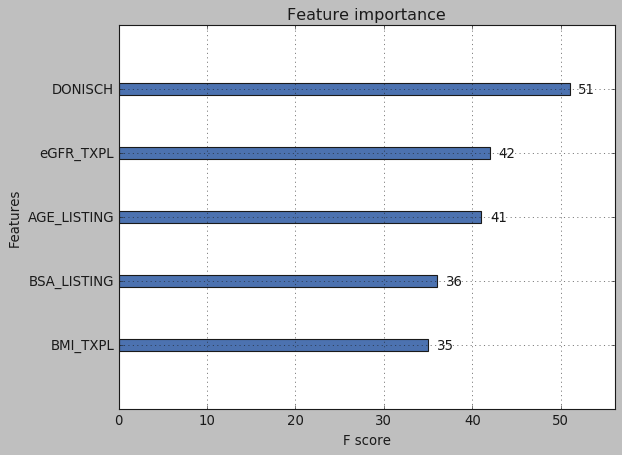

In [331]:
#I think this is neat
model = XGBClassifier()
model.fit(X_train, Y_train)

# plot feature importance
plt.style.use('classic')
plot_importance(model,max_num_features=5)
plt.show()

# SVC 

In [333]:
#Takes a while to run, results are similar to logistic regression
# svc_model = SVC(kernel='linear')
# print(modelPrediction(svc_model,X_train,Y_train,Y_test,X_test,"SVM",data,target))

# Logistic Regression

In [332]:
logit = LogisticRegression()

print(modelPrediction(logit,X_train,Y_train,Y_test,X_test,"Logisitc Regression"))

0  Model Name        Logisitc Regression
   Accuracy                        0.776
   Precision                       0.756
   Recall                          0.776
   F1 Score                        0.749
   AUC                             0.632
   True Negative                     948
   False Positive                     68
   False Negative                    240
   True Positive                     119
dtype: object


# Adding first text field - SURGERY HISTORY USING TF-IDF

In [334]:
#Only introducing one text field so keeping these out
df_model2 = df_processed.drop(['SPECOTH', 'CHD_OTHSP','CHD_SV','PATIENT_ID','CHD_HLH','CHD_TRIAT','CHD_DILV'], axis = 1) 

#Every column 
cols_temp2 = [col for col in df_model2.columns]

#All but predictor
df_model2 = df_model2[cols_temp2]

#Remove punctuation
df_model2["SURG_NO_PUNC"] = df_model2['SURGERY_HISTORY'].str.replace('[^\w\s]','')

#Drop SURGERY_HISTORY because I created SURG_NO_PUNC
df_model_drop = df_model2.drop('SURGERY_HISTORY',axis=1)

#If there are any missing data fill it with blank
df_model_drop['SURG_NO_PUNC'].fillna('', inplace=True)

#TDIDF VECTORIZER
tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english',tokenizer=word_tokenize)

score = tfidf.fit_transform(df_model_drop['SURG_NO_PUNC'])

df = pd.DataFrame(score.toarray(), columns=tfidf.get_feature_names())

df_model_drop = df_model_drop.drop('SURG_NO_PUNC',axis=1)

df_fin = pd.concat([df_model_drop.reset_index(drop=True),df.reset_index(drop=True)], axis=1)

print(df_fin['SV_GROUP'].value_counts())

#Get rid of missing less than 25 percent
filter_missing_wt = df_fin[df_fin.columns[df_fin.isnull().mean() < 0.25]]

filter_missing_wt

0    5068
1    1803
Name: SV_GROUP, dtype: int64


,AGE_LISTING,AGE_TXPL,SLVAD,SLECMO,SLVENT,HXARRYTH,HXCPR,HXDIAB,HXGI,HXMALIG,...,ware,wautologous,web,wfenestration,window,wire,wmvr,x,x3,xiphoid
0,15.855,16.047,0.000,0.000,0.000,1.000,nan,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,5.065,5.101,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,9.090,9.279,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.723,1.136,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,3.981,4.115,0.000,0.000,0.000,0.000,nan,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.148,0.446,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,4.893,5.098,0.000,0.000,0.000,1.000,nan,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,10.609,10.749,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.260,0.334,0.000,0.000,1.000,1.000,nan,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,17.599,17.621,0.000,1.000,1.000,1.000,nan,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [335]:
#Impute with the median
df_imp2 = filter_missing_wt.fillna(df_fin.median())

#Eliminate columns with duplicate names - duplicate words
df_imp2 = df_imp2.loc[:,~df_imp2.columns.duplicated()]

#Select all but predictor
first_text = [col for col in df_imp2.columns if col not in ['SV_GROUP']]

#If we only want to look at JUST the text, no continuous features
only_text = [col for col in df_imp2.columns if col not in df_imp.columns]

#The data with all columns but target
data_2 = df_imp2[first_text]

#The data with all columns but target
data_2_ot = df_imp2[only_text]

#The predictor
target_2 = df_imp2['SV_GROUP']

#Split the data
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(data_2,target_2, test_size = 0.2)

#Print dimensions
print(X_train_2.shape)
print(X_test_2.shape)
print(Y_train_2.shape)
print(Y_test_2.shape)

print(X_train_2.columns.values.tolist())

df_imp2.columns

(5496, 669)
(1375, 669)
(5496,)
(1375,)
['AGE_LISTING', 'AGE_TXPL', 'SLVAD', 'SLECMO', 'SLVENT', 'HXARRYTH', 'HXCPR', 'HXDIAB', 'HXGI', 'HXMALIG', 'HXNEURO', 'PACEMAKE', 'HXPERMYO', 'HXPRENAT', 'HXTRANS', 'HXRENINS', 'HXSHOCK', 'HXOTHER', 'HXMED', 'SLHOSP', 'RRACE_W', 'RRACE_B', 'RRACE_AI', 'RRACE_A', 'RRACE_PI', 'RRACE_O', 'RRACE_UN', 'TXO2', 'TXDOPA', 'TXDOBUT', 'TXISUPRO', 'TXNITRO', 'TXNPRUSS', 'TXPGE', 'TXIVINO', 'TXVENT', 'TXICU', 'DONISCH', 'DRACE_W', 'DRACE_B', 'DRACE_AI', 'DRACE_A', 'DRACE_PI', 'DRACE_O', 'BSA_LISTING', 'HEIGHT_TXPL', 'WEIGHT_TXPL', 'BSA_TXPL', 'BMI_TXPL', 'HEIGHT_DONOR', 'WEIGHT_DONOR', 'BSA_DONOR', 'LCREAT_R', 'LSSAB_R', 'TXCREAT_R', 'TXBUN_R', 'TXSA_R', 'eGFR_TXPL', 'GRAFT_LOSS', 'INT_GRAFT_LOSS', 'STATLIST_1', 'STATLIST_1A', 'STATLIST_1B', 'STATLIST_2', 'STATLIST_7', 'SLINODS_Dose Unknown', 'SLINODS_High Dose or Multiple IV', 'SLINODS_Single Low Dose', 'SEX_F', 'SEX_M', 'TXSTAT_1', 'TXSTAT_1A', 'TXSTAT_1B', 'TXSTAT_2', 'DONORSEX_F', 'DONORSEX_M', 'STATUS_L

Index(['AGE_LISTING', 'AGE_TXPL', 'SLVAD', 'SLECMO', 'SLVENT', 'HXARRYTH',
       'HXCPR', 'HXDIAB', 'HXGI', 'HXMALIG',
       ...
       'ware', 'wautologous', 'web', 'wfenestration', 'window', 'wire', 'wmvr',
       'x', 'x3', 'xiphoid'],
      dtype='object', length=670)

# Continuous Features + Surgery History Text

In [336]:
print(modelPrediction(logit,X_train_2,Y_train_2,Y_test_2,X_test_2,"Logistic Regression"))
# print(modelPrediction(svc_model,X_train_2,Y_train_2,Y_test_2,X_test_2,"SVM"))
print(modelPrediction(dt,X_train_2,Y_train_2,Y_test_2,X_test_2,"Decision Tree"))
print(modelPrediction(xg,X_train_2,Y_train_2,Y_test_2,X_test_2,"XG Boost"))

0  Model Name        Logistic Regression
   Accuracy                        0.849
   Precision                       0.844
   Recall                          0.849
   F1 Score                        0.845
   AUC                             0.779
   True Negative                     946
   False Positive                     82
   False Negative                    126
   True Positive                     221
dtype: object
0  Model Name        Decision Tree
   Accuracy                  0.823
   Precision                 0.821
   Recall                    0.823
   F1 Score                  0.822
   AUC                       0.761
   True Negative               910
   False Positive              118
   False Negative              126
   True Positive               221
dtype: object
0  Model Name        XG Boost
   Accuracy             0.873
   Precision            0.872
   Recall               0.873
   F1 Score             0.872
   AUC                  0.824
   True Negative          950
  

# ADD REMAINING TEXT

In [338]:
#New covariate list with first text field added
covariate_list_txt = ['CHD_OTHSP']

#Add these columns
cols2 = [col for col in df_processed.columns if col in covariate_list_txt]

df_model3 = df_processed[cols2]

#Remove punctuation
df_model3["CHD_NO_PUNC"] = df_model3['CHD_OTHSP'].str.replace('[^\w\s]','')

#Drop CHD_OTHSP because I created CHD_NO_PUNC
df_model_drop2 = df_model3.drop('CHD_OTHSP',axis=1)

#Changed all blanks to missing
df_model_drop2['CHD_NO_PUNC'].fillna('', inplace=True)

tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english',tokenizer=word_tokenize)
score = tfidf.fit_transform(df_model_drop2['CHD_NO_PUNC'])

# New data frame containing the tfidf features and their scores
df2 = pd.DataFrame(score.toarray(), columns=tfidf.get_feature_names())

df_fin2 = pd.concat([df_imp2.reset_index(drop=True),df2.reset_index(drop=True)], axis=1)

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
print(df_fin2['SV_GROUP'].value_counts())

#Get rid of missing less than 25 percent
filter_missing_wt2 = df_fin2[df_fin2.columns[df_fin2.isnull().mean() < 0.25]]


filter_missing_wt2

0    5068
1    1803
Name: SV_GROUP, dtype: int64


,AGE_LISTING,AGE_TXPL,SLVAD,SLECMO,SLVENT,HXARRYTH,HXCPR,HXDIAB,HXGI,HXMALIG,...,vsd,vsd,vsds,w,wall,wi,wiht,wventricular,x,x
0,15.855,16.047,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,5.065,5.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,9.090,9.279,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.723,1.136,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,3.981,4.115,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.148,0.446,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,4.893,5.098,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,10.609,10.749,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.260,0.334,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,17.599,17.621,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [339]:
df_imp3 = filter_missing_wt2

#Eliminate duplicate columns
df_imp3 = df_imp3.loc[:,~df_imp3.columns.duplicated()]

first_text = [col for col in df_imp3.columns if col not in ['SV_GROUP']]

only_text = [col for col in df_imp3.columns if col not in df_imp.columns]

#The data with all columns but target
data_3 = df_imp3[first_text]

#The predictor
target_3 = df_imp3['SV_GROUP']

#Split the data
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(data_3,target_3, test_size = 0.2)

#Print dimensions
print(X_train_3.shape)
print(X_test_3.shape)
print(Y_train_3.shape)
print(Y_test_3.shape)

print(X_train_3.columns.values.tolist())


(5496, 1053)
(1375, 1053)
(5496,)
(1375,)
['AGE_LISTING', 'AGE_TXPL', 'SLVAD', 'SLECMO', 'SLVENT', 'HXARRYTH', 'HXCPR', 'HXDIAB', 'HXGI', 'HXMALIG', 'HXNEURO', 'PACEMAKE', 'HXPERMYO', 'HXPRENAT', 'HXTRANS', 'HXRENINS', 'HXSHOCK', 'HXOTHER', 'HXMED', 'SLHOSP', 'RRACE_W', 'RRACE_B', 'RRACE_AI', 'RRACE_A', 'RRACE_PI', 'RRACE_O', 'RRACE_UN', 'TXO2', 'TXDOPA', 'TXDOBUT', 'TXISUPRO', 'TXNITRO', 'TXNPRUSS', 'TXPGE', 'TXIVINO', 'TXVENT', 'TXICU', 'DONISCH', 'DRACE_W', 'DRACE_B', 'DRACE_AI', 'DRACE_A', 'DRACE_PI', 'DRACE_O', 'BSA_LISTING', 'HEIGHT_TXPL', 'WEIGHT_TXPL', 'BSA_TXPL', 'BMI_TXPL', 'HEIGHT_DONOR', 'WEIGHT_DONOR', 'BSA_DONOR', 'LCREAT_R', 'LSSAB_R', 'TXCREAT_R', 'TXBUN_R', 'TXSA_R', 'eGFR_TXPL', 'GRAFT_LOSS', 'INT_GRAFT_LOSS', 'STATLIST_1', 'STATLIST_1A', 'STATLIST_1B', 'STATLIST_2', 'STATLIST_7', 'SLINODS_Dose Unknown', 'SLINODS_High Dose or Multiple IV', 'SLINODS_Single Low Dose', 'SEX_F', 'SEX_M', 'TXSTAT_1', 'TXSTAT_1A', 'TXSTAT_1B', 'TXSTAT_2', 'DONORSEX_F', 'DONORSEX_M', 'STATUS

In [340]:
print(modelPrediction(logit,X_train_3,Y_train_3,Y_test_3,X_test_3,"Logistic Regression"))

print(modelPrediction(dt,X_train_3,Y_train_3,Y_test_3,X_test_3,"Decision Tree"))

# print(modelPrediction(svc_model,X_train_3,Y_train_3,Y_test_3,X_test_3,"SVM"))

print(modelPrediction(xg,X_train_3,Y_train_3,Y_test_3,X_test_3,"XG Boost"))

0  Model Name        Logistic Regression
   Accuracy                        0.785
   Precision                       0.774
   Recall                          0.785
   F1 Score                        0.773
   AUC                             0.692
   True Negative                     895
   False Positive                     91
   False Negative                    204
   True Positive                     185
dtype: object
0  Model Name        Decision Tree
   Accuracy                  0.812
   Precision                 0.807
   Recall                    0.812
   F1 Score                  0.808
   AUC                       0.753
   True Negative               876
   False Positive              110
   False Negative              149
   True Positive               240
dtype: object
0  Model Name        XG Boost
   Accuracy             0.885
   Precision            0.883
   Recall               0.885
   F1 Score             0.883
   AUC                  0.840
   True Negative          931
  

# Only text fields Surgery History + CHD Specify

In [341]:
#The data with all columns but target
data_3 = df_imp3[only_text]

#The predictor
target_3 = df_imp3['SV_GROUP']

#Split the data
X_train_3_text, X_test_3_text, Y_train_3_text, Y_test_3_text = train_test_split(data_3,target_3, test_size = 0.2)

#Print dimensions
print(X_train_3_text.shape)
print(X_test_3_text.shape)
print(Y_train_3_text.shape)
print(Y_test_3_text.shape)

print(X_train_3_text.columns.values.tolist())

print(modelPrediction(logit,X_train_3_text,Y_train_3_text,Y_test_3_text,X_test_3_text,"Logistic Regression"))

print(modelPrediction(dt,X_train_3_text,Y_train_3_text,Y_test_3_text,X_test_3_text,"Decision Tree"))

#Just commenting it out because it takes a long time to run-results were similiar to logistic regrssion
#print(modelPrediction(svc_model,X_train_3_text,Y_train_3_text,Y_test_3_text,X_test_3_text,"SVM"))

print(modelPrediction(xg,X_train_3_text,Y_train_3_text,Y_test_3_text,X_test_3_text,"XG Boost"))


(5496, 959)
(1375, 959)
(5496,)
(1375,)
['1', '10mm', '17', '17arterial', '17l', '17pda', '17reimplantation', '18', '19', '19balloon', '2', '20', '2004', '20atria', '21', '29', '2nd', '30', '31', '32', '33', '34', '35', '36', '4', '40', '41', '42', '44', '45', '46', '47', '48', '4mm', '5', '51', '52', '53', '54', '59', '61', '64', '66', '68', '69', '72', '73', '77', '85', '86', '88', '91', 'aa', 'ablation', 'aborted', 'absent', 'acs', 'aicd', 'aicdsub', 'alca', 'alcapa', 'anamolous', 'anastamosis', 'anastomosis', 'aneurysm', 'angioplasty', 'annuloplasty', 'anomalous', 'anomaly', 'anomylous', 'anuersym', 'anuloplasty', 'anurysm', 'ao', 'aorta', 'aortalv', 'aortic', 'aortico', 'ap', 'application', 'approach', 'arc', 'arch', 'aromolous', 'arrest', 'arterial', 'arteries', 'arterioplasty', 'arteriosus', 'artery', 'artrial', 'ascending', 'asd', 'assist', 'atrial', 'atrioseptostomy', 'attempted', 'augmentation', 'av', 'avr', 'avrst', 'ballon', 'balloon', 'baloon', 'bana', 'band', 'banding', '

## Feature Importance for Model

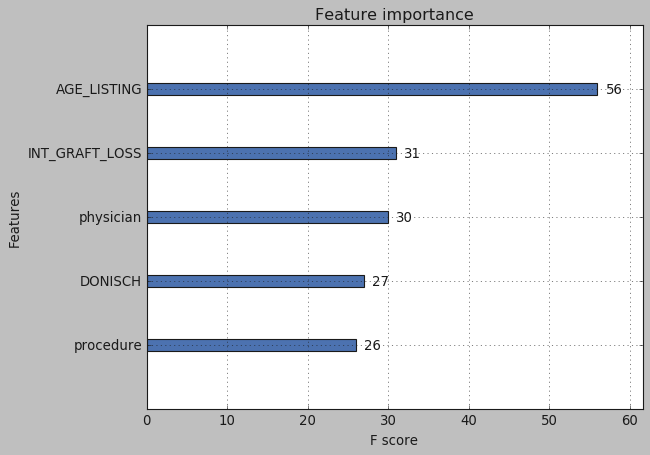

In [229]:
XGBClassifier().fit(X_train_3, Y_train_3)
plot_importance(model,max_num_features=5)
plt.style.use('classic')
plt.show()

## Bio2vec Word Embeddings Instead of TF-IDF

In [342]:
#Tobias made this using bio2vec
df_bio = pd.read_excel('row2vect.xlsx')

df_processed.sort_values(by=['PATIENT_ID'])

#Combine with our original dataset, everything is sorted by patient ID 
df_biovec = pd.concat([df_processed.reset_index(drop=True),df_bio.reset_index(drop=True)], axis=1)

In [347]:
#We don't want to include these guys because CHD_DILV CHD_TRIAT AND CHD_HLH are surgeries that are ALWAYS single ventricle
#I don't want them to bias the model
ex_vars = ['CHD_DILV','CHD_TRIAT','CHD_HLH','PATIENT_ID','SURGERY_HISTORY','CHD_SV']

#Add these columns
cols2 = [col for col in df_biovec.columns if col not in ex_vars]

#Set this up for machine learning
df_biovec2 = df_biovec[cols2]

#Get rid of missing less than 25 percent
filter_missing_wt = df_biovec2[df_biovec2.columns[df_biovec2.isnull().mean() < 0.25]]

#Impute with the median
df_imp4 = filter_missing_wt.fillna(df_fin.median())

#All columns but the target
all = [col for col in df_imp4.columns if col not in ['SV_GROUP']]

#Only word embeddings
cols_only_text = [col for col in df_imp4.columns if col not in df_processed.columns]

#Data with everything
data_4 = df_imp4[all]

#Data with only text
data_4t = df_imp4[cols_only_text]

#The predictor
target_4 = df_imp4['SV_GROUP']

#Split the data
X_train_4, X_test_4, Y_train_4, Y_test_4 = train_test_split(data_4,target_4, test_size = 0.2)

#Print dimensions
print(X_train_4.shape)
print(X_test_4.shape)
print(Y_train_4.shape)
print(Y_test_4.shape)

print(X_train_4.columns.values.tolist())

(5496, 294)
(1375, 294)
(5496,)
(1375,)
['AGE_LISTING', 'AGE_TXPL', 'SLVAD', 'SLECMO', 'SLVENT', 'HXARRYTH', 'HXCPR', 'HXDIAB', 'HXGI', 'HXMALIG', 'HXNEURO', 'PACEMAKE', 'HXPERMYO', 'HXPRENAT', 'HXTRANS', 'HXRENINS', 'HXSHOCK', 'HXOTHER', 'HXMED', 'SLHOSP', 'RRACE_W', 'RRACE_B', 'RRACE_AI', 'RRACE_A', 'RRACE_PI', 'RRACE_O', 'RRACE_UN', 'TXO2', 'TXDOPA', 'TXDOBUT', 'TXISUPRO', 'TXNITRO', 'TXNPRUSS', 'TXPGE', 'TXIVINO', 'TXVENT', 'TXICU', 'DONISCH', 'DRACE_W', 'DRACE_B', 'DRACE_AI', 'DRACE_A', 'DRACE_PI', 'DRACE_O', 'BSA_LISTING', 'HEIGHT_TXPL', 'WEIGHT_TXPL', 'BSA_TXPL', 'BMI_TXPL', 'HEIGHT_DONOR', 'WEIGHT_DONOR', 'BSA_DONOR', 'LCREAT_R', 'LSSAB_R', 'TXCREAT_R', 'TXBUN_R', 'TXSA_R', 'eGFR_TXPL', 'GRAFT_LOSS', 'INT_GRAFT_LOSS', 'STATLIST_1', 'STATLIST_1A', 'STATLIST_1B', 'STATLIST_2', 'STATLIST_7', 'SLINODS_Dose Unknown', 'SLINODS_High Dose or Multiple IV', 'SLINODS_Single Low Dose', 'SEX_F', 'SEX_M', 'TXSTAT_1', 'TXSTAT_1A', 'TXSTAT_1B', 'TXSTAT_2', 'DONORSEX_F', 'DONORSEX_M', 'STATUS_L

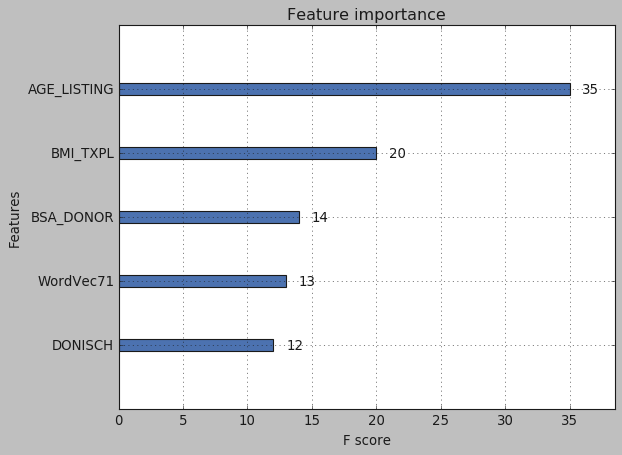

In [348]:
#print(modelPrediction(xg,X_train_4,Y_train_4,Y_test_4,X_test_4,"XG Boost"))

model = XGBClassifier()
model.fit(X_train_4, Y_train_4)
plot_importance(model,max_num_features=5)
plt.style.use('classic')
plt.show()

## Only word embeddings from bio2vec

In [349]:
#Split the data
X_train_4t, X_test_4t, Y_train_4t, Y_test_4t = train_test_split(data_4t,target_4, test_size = 0.2)

#Print dimensions
print(X_train_4t.shape)
print(X_test_4t.shape)
print(Y_train_4t.shape)
print(Y_test_4t.shape)

print(X_train_4t.columns.values.tolist())

print(modelPrediction(xg,X_train_4t,Y_train_4t,Y_test_4t,X_test_4t,"XG Boost"))

(5496, 200)
(1375, 200)
(5496,)
(1375,)
['WordVec0', 'WordVec1', 'WordVec2', 'WordVec3', 'WordVec4', 'WordVec5', 'WordVec6', 'WordVec7', 'WordVec8', 'WordVec9', 'WordVec10', 'WordVec11', 'WordVec12', 'WordVec13', 'WordVec14', 'WordVec15', 'WordVec16', 'WordVec17', 'WordVec18', 'WordVec19', 'WordVec20', 'WordVec21', 'WordVec22', 'WordVec23', 'WordVec24', 'WordVec25', 'WordVec26', 'WordVec27', 'WordVec28', 'WordVec29', 'WordVec30', 'WordVec31', 'WordVec32', 'WordVec33', 'WordVec34', 'WordVec35', 'WordVec36', 'WordVec37', 'WordVec38', 'WordVec39', 'WordVec40', 'WordVec41', 'WordVec42', 'WordVec43', 'WordVec44', 'WordVec45', 'WordVec46', 'WordVec47', 'WordVec48', 'WordVec49', 'WordVec50', 'WordVec51', 'WordVec52', 'WordVec53', 'WordVec54', 'WordVec55', 'WordVec56', 'WordVec57', 'WordVec58', 'WordVec59', 'WordVec60', 'WordVec61', 'WordVec62', 'WordVec63', 'WordVec64', 'WordVec65', 'WordVec66', 'WordVec67', 'WordVec68', 'WordVec69', 'WordVec70', 'WordVec71', 'WordVec72', 'WordVec73', 'WordVe